In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(stringr))
library(ggplot2)
library(ggrepel)


In [3]:
df<-read.csv("02_DEGs_and_EnrichmentAnalysis/df_filtered_cd27neg_effector_B.csv")

In [4]:
df <- df %>%
  mutate(
    neg_log10_pvalue = -log10(pvalue),
    significant = padj < 0.05,
    nominally_significant = pvalue < 0.05 & padj >= 0.05,
    regulation = case_when(
      significant & log2FoldChange < 0 ~ "Up in OA",
      significant & log2FoldChange > 0 ~ "Up in YA",
      nominally_significant & log2FoldChange < 0 ~ "Nominal Up in OA",
      nominally_significant & log2FoldChange > 0 ~ "Nominal Up in YA",
      TRUE ~ "Not significant"
    ))

In [5]:
genes_to_label <- c("CD19", "IGHM", "IGHD", "TBX21", "ZEB2", "MS4A1", "ITGAX", "XBP1", "DAPP1", "S100A10", 
                    "FCRL5", "CXCR5", "BCL2", "TCF7", "BATF", "CXCR3", "CXCR4")


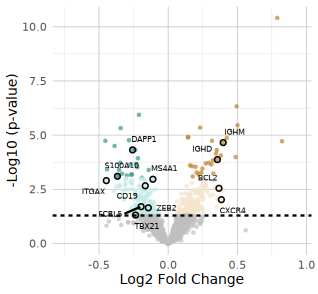

In [8]:



options(repr.plot.width=65/24.5, repr.plot.height=60/24.5 )
# Create the volcano plot
volcano_plot <- ggplot(df, aes(x = -log2FoldChange, y = neg_log10_pvalue)) +
  geom_point(aes(color = regulation),stroke=0, alpha = 0.7, size = 1) +  
  scale_color_manual(values = c(
    "Up in OA" = "#bf812d", 
    "Up in YA" = "#35978f", 
    "Nominal Up in OA" = "#F3E4CD", 
    "Nominal Up in YA" = "#C3EAE7", 
    "Not significant" = "gray"
  )) +  
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black") +
  geom_point(data = subset(df, gene %in% genes_to_label), 
             aes(x = -log2FoldChange, y = neg_log10_pvalue),
             color = "black", fill = NA, shape = 21, size = 1) +  # Add black border to specific points
  geom_text_repel(data = subset(df, gene %in% genes_to_label), 
                  aes(label = gene), 
                  size = 1.5,  # Increase the size of the text labels
                  max.overlaps = Inf) +
  labs(title = "CD27- Effector Memory",
       x = "Log2 Fold Change",
       y = "-Log10 (p-value)",
       color = "Legend") +
  theme_minimal(base_size = 8) +
  theme(
    plot.title = element_blank(), 
    panel.grid.major = element_line(colour = "grey", linewidth = 0.15),  
    panel.grid.minor = element_line(colour = "grey", linewidth = 0.05), 
    legend.position = "none"
  )+  scale_x_continuous(limits = c(-0.75, 0.95))

volcano_plot
ggsave('FigureE.pdf',volcano_plot, width=65/25.4, height=60/25.4)